# Convolutional Variational Autoencoder using the MNIST dataset (TensorFlow backend)

## Introduction to CVAE

CVAEs are Convolutional Variational Autoencoders. They are composed of two models using convolutions: an encoder to cast the input into a latent dimension, and a decoder that will move data from the latent dimension back to the input space. The figure below illustrates the main idea behind CVAEs. 


In this example, we will use a CVAE to generate data similar to the MNIST dataset using the TensorFlow backend. All training details including model structure, data preprocessing, loss calculation, etc. come from the [TensorFlow CVAE tutorial](https://www.tensorflow.org/tutorials/generative/cvae)
![cvae](./VAE_complete.png)

## Import the required libraries

In [1]:
import tensorflow as tf
import fastestimator as fe
import numpy as np
import tempfile
import matplotlib.pyplot as plt
from typing import Any, Dict, Tuple
from fastestimator.util import BatchDisplay, GridDisplay

In [2]:
#training parameters
epochs = 20
batch_size = 100
train_steps_per_epoch = None
save_dir = tempfile.mkdtemp()

## Step 1 - Data and `Pipeline` preparation
In this step, we will load MNIST training and validation dataset and prepare FastEstimator's data `Pipeline`.

### Load dataset 
Let's use a FastEstimator API to load the MNIST dataset: 

In [3]:
from fastestimator.dataset.data.mnist import load_data

train_data, test_data = load_data()

### Set up the preprocessing `Pipline`
In this example, the data preprocessing steps include expanding image dimension, normalizing the image pixel values to the range [0, 1], and binarizing pixel values. We set up these processing steps using `Ops`, while also defining the data source and batch size for the `Pipeline`.

In [4]:
from fastestimator.op.numpyop.univariate import Binarize, ExpandDims, Minmax

pipeline = fe.Pipeline(
    train_data=train_data,
    batch_size=batch_size,
    ops=[
        ExpandDims(inputs="x", outputs="x_out"), # change image size: (None, 28, 28) -> (None, 28, 28, 1) 
        Minmax(inputs="x_out", outputs="x_out"), # normalize pixel value: [0, 255] -> [0, 1] 
        Binarize(inputs="x_out", outputs="x_out", threshold=0.5) # binarize pixel value
    ])

### Validate `Pipeline`
In order to make sure the pipeline works as expected, we need to visualize its output. `Pipeline.get_results` will return a batch of data for this purpose:  

In [5]:
data = pipeline.get_results()
data_xin = data["x"]
data_xout = data["x_out"]
print("the pipeline input data size: {}".format(data_xin.numpy().shape))
print("the pipeline output data size: {}".format(data_xout.numpy().shape))

the pipeline input data size: (100, 28, 28)
the pipeline output data size: (100, 28, 28, 1)


Let's select 5 samples and visualize the differences between the `Pipeline` input and output.

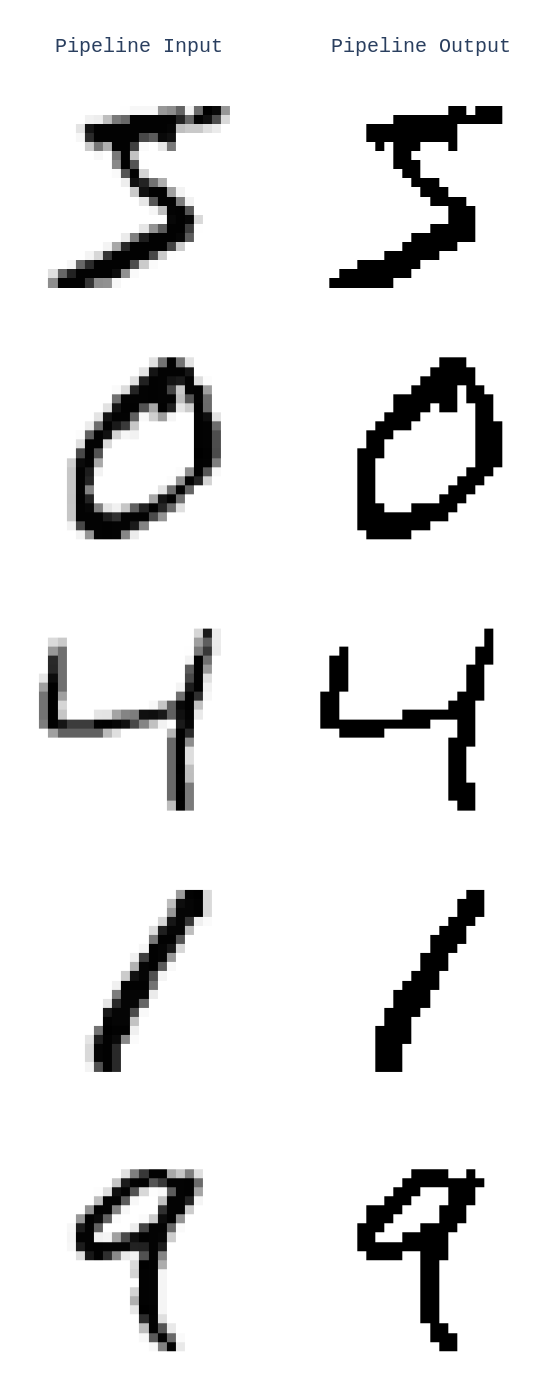

In [6]:
sample_num = 5

GridDisplay([BatchDisplay(image=data_xin[0:sample_num], title="Pipeline Input"), 
             BatchDisplay(image=data_xout[0:sample_num], title="Pipeline Output")]).show()

## Step 2 - `Network` construction
**FastEstimator supports both PyTorch and TensorFlow, so this section could use either backend.** <br>
We are going to only demonstrate the TensorFlow backend in this example.

### Model construction
Both of our models' definitions are implemented in TensorFlow and instantiated by calling `fe.build` (which also associates the model with specific optimizers).

In [7]:
LATENT_DIM = 2

def encoder_net():
    infer_model = tf.keras.Sequential()
    infer_model.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 1)))
    infer_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'))
    infer_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'))
    infer_model.add(tf.keras.layers.Flatten())
    infer_model.add(tf.keras.layers.Dense(LATENT_DIM + LATENT_DIM))
    return infer_model


def decoder_net():
    generative_model = tf.keras.Sequential()
    generative_model.add(tf.keras.layers.InputLayer(input_shape=(LATENT_DIM, )))
    generative_model.add(tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu))
    generative_model.add(tf.keras.layers.Reshape(target_shape=(7, 7, 32)))
    generative_model.add(
        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'))
    generative_model.add(
        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'))
    generative_model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation='sigmoid'))
    return generative_model

encode_model = fe.build(model_fn=encoder_net, optimizer_fn="adam", model_name="encoder")
decode_model = fe.build(model_fn=decoder_net, optimizer_fn="adam", model_name="decoder")

2022-05-17 22:36:32.431886: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-17 22:36:33.263045: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:90:00.0, compute capability: 8.0


### Customize `Ops` 
`Ops` are the basic components of a `Network`. They can be logic for loss calculation, model update units, or even the model itself. Some `Ops` such as cross entropy are pre-defined in FastEstimator, but for any logic that is not there yet, users need to define their own `Ops`. **Please keep all custom `Ops` backend-consistent with your model backend**. In this case all `Ops` need to be implemented in TensorFlow since our model is built from Tensorflow.      

#### Customize Ops - SplitOp
Because the encoder output contains both mean and log of variance, we need to split them into two outputs: 

In [8]:
from fastestimator.op.tensorop import TensorOp

class SplitOp(TensorOp):
    """To split the infer net output into two """
    def forward(self, data: tf.Tensor, state: Dict[str, Any]) -> Tuple[tf.Tensor, tf.Tensor]:
        mean, logvar = tf.split(data, num_or_size_splits=2, axis=1)
        return mean, logvar

#### Customize Ops - ReparameterizeOp
In this example case, the input to the decoder is a random sample from a normal distribution whose mean and variation are the output of the encoder. We are going to build an `Op` called "ReparameterizeOp" to accomplish this:

In [9]:
class ReparameterizeOp(TensorOp):
    def forward(self, data: Tuple[tf.Tensor, tf.Tensor], state: Dict[str, Any]) -> tf.Tensor:
        mean, logvar = data
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

#### Customize Ops - CVAELoss

In [10]:
import math

class CVAELoss(TensorOp):
    def forward(self, data: Tuple[tf.Tensor, ...], state: Dict[str, Any]) -> tf.Tensor:
        cross_ent_mean, mean, logvar, z = data   
        
        cross_ent_total = cross_ent_mean * (28 * 28 * 1) # cross_ent_mean is the average cross entropy over pixels and batches 
                                                         # make it total cross entropy over pixels 
        logpz = self._log_normal_pdf(z, 0., 0.)
        logqz_x = self._log_normal_pdf(z, mean, logvar)
        total_loss = cross_ent_total + tf.reduce_mean(-logpz + logqz_x)

        return total_loss
    
    @staticmethod
    def _log_normal_pdf(sample, mean, logvar, raxis=1):
        log2pi = tf.math.log(2. * tf.constant(math.pi))
        return tf.reduce_sum(-.5 * ((sample - mean)**2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

### `Network` definition
We are going to connect all models and `Ops` together into a `Network` 

In [11]:
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp

network = fe.Network(ops=[
    ModelOp(model=encode_model, inputs="x_out", outputs="meanlogvar"),
    SplitOp(inputs="meanlogvar", outputs=("mean", "logvar")),
    ReparameterizeOp(inputs=("mean", "logvar"), outputs="z"), 
    ModelOp(model=decode_model, inputs="z", outputs="x_logit"),
    CrossEntropy(inputs=("x_logit", "x_out"), outputs="cross_entropy"), 
    CVAELoss(inputs=("cross_entropy", "mean", "logvar", "z"), outputs="loss", mode="!infer"),
    UpdateOp(model=encode_model, loss_name="loss"),
    UpdateOp(model=decode_model, loss_name="loss"),
])

2022-05-17 22:36:34.215892: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Step 3 - `Estimator` definition and training
In this step, we define the `Estimator` to compile the `Network` and `Pipeline` and indicate in `traces` that we want to save the best models. We can then use `estimator.fit()` to start the training process:

In [12]:
from fastestimator.trace.io import ModelSaver

traces = [ModelSaver(model=encode_model, save_dir=save_dir, frequency=epochs), 
          ModelSaver(model=decode_model, save_dir=save_dir, frequency=epochs)]

estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=epochs,
                         traces=traces,
                         train_steps_per_epoch=train_steps_per_epoch,
                         log_steps=600)

estimator.fit() # start the training process

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: the key 'x' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.
FastEstimator-Warn: the key 'y' is being pruned since it is unused outside of the Pipeline. To prevent this, you can declare the key as an input of a Trace or TensorOp.


2022-05-17 22:36:42.024562: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-05-17 22:36:43.959941: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


FastEstimator-Start: step: 1; logging_interval: 600; num_device: 1;
FastEstimator-Train: step: 1; loss: 544.2965;
FastEstimator-Train: step: 600; loss: 172.18253; steps/sec: 184.56;
FastEstimator-Train: step: 600; epoch: 1; epoch_time: 9.7 sec;
FastEstimator-Train: step: 1200; loss: 161.00087; steps/sec: 71.45;
FastEstimator-Train: step: 1200; epoch: 2; epoch_time: 8.39 sec;
FastEstimator-Train: step: 1800; loss: 152.92236; steps/sec: 72.24;
FastEstimator-Train: step: 1800; epoch: 3; epoch_time: 8.36 sec;
FastEstimator-Train: step: 2400; loss: 161.80312; steps/sec: 77.87;
FastEstimator-Train: step: 2400; epoch: 4; epoch_time: 7.46 sec;
FastEstimator-Train: step: 3000; loss: 153.76183; steps/sec: 101.51;
FastEstimator-Train: step: 3000; epoch: 5; epoch_time: 5.93 sec;
FastEstimator-Train: step: 3600; loss: 146.66841; steps/sec: 99.31;
FastEstimator-Train: step: 3600; epoch: 6; epoch_time: 6.03 sec;
FastEstimator-Train: step: 4200; loss: 166.19159; steps/sec: 104.04;
FastEstimator-Train:

## Inferencing

Once the model is trained, we will try to run our models to generate images by sampling from the latent space:

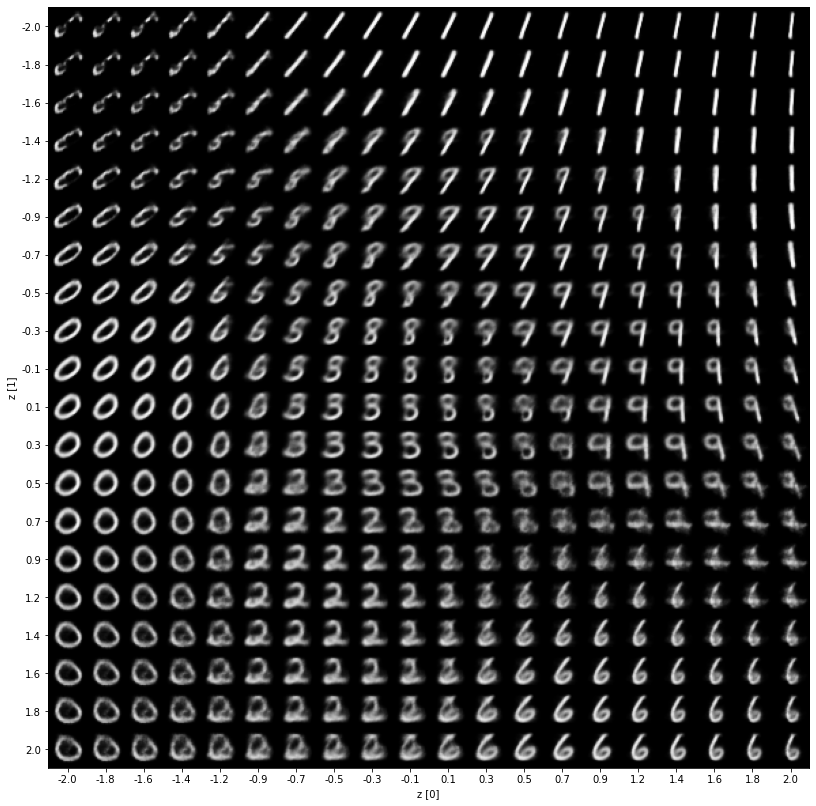

In [13]:
scale = 2.0 
n = 20
img_size = 28
figure = np.zeros((img_size * n, img_size * n))

grid_x = np.linspace(-scale, scale, n)
grid_y = np.linspace(-scale, scale, n)

network = fe.Network(ops=[
    ModelOp(model=decode_model, inputs="z", outputs="x_logit"),
])

for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        data = {"z": np.array([[xi, yi]])}
        data = network.transform(data, mode="infer")
        figure[i * img_size : (i + 1) * img_size, 
               j * img_size : (j + 1) * img_size] = data["x_logit"].numpy().squeeze(axis=(0,3))

plt.figure(figsize=(14, 14))
pixel_range = np.arange(img_size//2, n * img_size + img_size//2, img_size)
plt.xticks(pixel_range, np.round(grid_x, 1))
plt.yticks(pixel_range, np.round(grid_y, 1))
plt.xlabel("z [0]")
plt.ylabel("z [1]")
plt.imshow(figure, cmap="gray")
plt.show()